# Imaging Tutorial with the Sparse Modeling Technique

This notebook is a tutorial of synthesis imaging based on the sparse modeling technique using PRIISM. 
<b>PRIISM</b> is an imaging tool for radio interferometry based on the sparse modeling technique (<a href="https://github.com/tnakazato/priism" target="_blank" rel="noopener">PRIISM</a>: Python Module for Radio Interferometry Imaging with Sparse Modeling). 
In the tutorial, we try synthesis imaging for ALMA interferometry data using PRIISM. 

## ALMA Data : TW Hya

Sample data for the tutorial is the protoplanetary disk "<b>TW Hydra</b>" observed at Band 7 with ALMA 12m array (Project 2011.0.00340.S). 
The data infromation is taken in <a href="https://casaguides.nrao.edu/index.php?title=First_Look_at_Imaging_CASA_6" target="_blank" rel="noopener">First Look at Imaging CASA 6</a>, and the data, which is a calibrated measurement set (MS) for CASA, can be downloaded from the link below: <br>
&emsp; <a href="https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar" target="_blank" rel="noopener">https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar</a>

## Setup PRIISM

Before you start the tutorial, you should install PRIISM and packages that PRIISM depends on, such as <code>casatools</code> and <code>casatasks</code>. <br>
Hereafter, we suppose that PRIISM was installed using Python <code>setuptools</code> combined with CASA 6 modular release in a virtual environment. 

### Activate Virtual Environment and Python PATH

The tutorial should be processed under the python virtual environment installed PRIISM. 
Before Jupyter Notebook start, you should activate the virtual environment created by <code>venv</code> as follows,
<pre style="width: 500px; margin: 10px; padding: solid 3px; background-color: #f0f8ff;">
<code style="background-color: #f0f8ff;"># In command line</code>
<code style="background-color: #f0f8ff;">source [virtual environment name with path]/bin/activate</code>
</pre>
And also, the python path should be set. 
If PRIISM import fails in the next step, please set the python path as follows,
<pre style="width: 500px; margin: 10px; padding: solid 3px; background-color: #ffffe0;">
<code style="background-color: #ffffe0;"># In python</code>
<code style="background-color: #ffffe0;">import sys</code>
<code style="background-color: #ffffe0;">sys.path.append('[virtual environment name with path]/lib/python3.8/site-packages')</code>
<code style="background-color: #ffffe0;">sys.path.append('[virtual environment name with path]/lib/python3.8/site-packages/priism-0.11.3-py3.8.egg')</code></pre>
It is necessary to modify these to match the PRIISM installation in your environment. 

In [ ]:
#import sys, pprint
#sys.path.append('[virtual environment name with path]/lib/python3.8/site-packages')
#sys.path.append('[virtual environment name with path]/lib/python3.8/site-packages/priism-0.11.3-py3.8.egg')
#pprint.pprint(sys.path)

### Initialization PRIISM

PRIISM includes two modules <code>priism.core</code> and <code>priism.alma</code>. The former is a set of core functionalities and primitive interface while the later is high-level interface specific to ALMA data. You should import at least <code>priism.alma</code> module in this tutorial. <br>
And also, the execution module <code>runner</code> that allows us to easily run PRIISM is imported.

In [ ]:
import os, sys
import priism.alma
print(f'PRIISM version {priism.__version__}')
from priism.runner import runner

PRIISM version 0.11.3


Matplotlib figures are made to be displayed in the notebook.

In [ ]:
%matplotlib inline

## Data Preparation

### Download Data

Here, the sample visibility data mentioned above is downloaded. 
The data set is downloaded and extended. 
The compressed tar file includes a calibrated measurement set (MS) for CASA. 

In [ ]:
import subprocess

# download data
base_url = 'https://bulk.cv.nrao.edu/almadata/public/working/'
data_tgz = 'sis14_twhya_calibrated_flagged.ms.tar'
data_dir = 'sis14_twhya_calibrated_flagged.ms'

if not os.path.exists(data_tgz):
    subprocess.run(['wget', base_url + data_tgz])
    print("Data download successful.")

if not os.path.exists(data_dir):
    subprocess.run(['tar', 'xf', data_tgz])
    print("Data extended tar successful.")

Data download successful.
Data extended tar successful.


### Preparation of Measurement Set

If you want, visibility channels in the MS data can be averaged to apply to PRIISM. 
Here, the task <code>split</code> in <code>casatasks</code>, that should have been installed as a dependency of PRIISM, split visivility data of the assigned target field and spectral window (spw), with averaging if needed. <br>

<code>orgvis</code> is a name of the calibrated MS that is downloaded as mentioned above. 
The MS data assigned in <code>vis</code> will be used in the subsequent steps. 
The details of the visibility (MS) data are outputted as "<code>*.listobs</code>" files.

In [ ]:
from casatasks import split, listobs
orgvis = data_dir
vis = 'twhya_b7cont.smoothed.ms'
field='5' # field ID
spw='0'   # spectral window (spw) ID
os.system('rm -rf '+vis)
split(vis=orgvis, outputvis=vis,
      field=field, spw=spw, width='8', datacolumn='data')
info1=listobs(vis=orgvis, listfile=orgvis+'.listobs', 
              verbose=False, overwrite=True)
info2=listobs(vis=vis, listfile=vis+'.listobs', 
              verbose=False, overwrite=True)
print("# Data split has finished.")

# Data split has finished.


In [ ]:
!cat sis14_twhya_calibrated_flagged.ms.listobs | grep ALMA_RB_
!cat twhya_b7cont.smoothed.ms.listobs | grep ALMA_RB_

  0      ALMA_RB_07#BB_2#SW-01#FULL_RES    384   TOPO  372533.086       610.352    234375.0 372649.9688        2  XX  YY
  0      ALMA_RB_07#BB_2#SW-01#FULL_RES     48   TOPO  372535.223      4882.812    234375.0 372649.9688        2  XX  YY


## Image Configuration

Here, the parameters in the input visivility (MS) data and the output image are set. At first, the class <code>Session</code> is declared from the execution module <code>runner</code> mentioned above. <br>
In <code>setDataParam</code>, only single field data can be accepted now. <br>
In <code>setImageParam</code>, note that <code>nchan</code> should be 1. These limitation may be relaxed in the future. <br>
Total number of <code>ch</code> in the input visivility parameters (<code>setDataParam</code>) should be consistent with <code>nchan</code>&times;<code>width</code> in the output image parameters (<code>setImageParam</code>). 

In [ ]:
h=runner.Session(vis)
h.setDataParam(field='0', spw='0', ch='24~25')
h.setImageParam(imsize=[256, 256], cell=['0.08arcsec'],
                nchan=1, start=0, width=2)

#############################
(runner.Session): vis = twhya_b7cont.smoothed.ms


## Direct Imaging

An image is created from the visibility (MS) data. There are two parameters for imaging: <code>L1</code> and <code>Ltsv</code>. They are hyper parameters for regularization terms. Once you give these parameters, you will obtain one image. 
To make execution duration short, max iteration is limited to <code>maxiter</code>. 
The resultant image is exported to FITS file named as <code>dimname</code>. <br>
That resulting image with these following parameters is scientifically optimized. You should perform cross-validation to obtain more reliable image.

In [ ]:
%%timeit -n 1 -r 1
%%capture --no-display capture_cv

dimname = 'twhya_b7cont.fits'
h.setImageParam(imname=dimname)
h.setSpParam(l1=1e3, ltsv=1e7, maxiter=1000)
h.run(overwrite=True)
h.saveParam('twhya.dimg.param', overwrite=True)

6.86 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Cross-Validation: Finding the Most Reliable Image

In the previous step, <code>L1</code> and <code>Ltsv</code> are treated as fixed parameters. In practice, however, these parameters must be optimized to obtain the most reliable image for given visibility data. PRIISM implements a cross validation for optimization. In general, cross validation is time-consuming process because it requires to solve the problem many times and we need to search broad range of L1-Ltsv parameter space. This step is a shorthand for cross validation. We will search only 3&times;3 parameter space (<code>L1_list</code> and <code>Ltsv_list</code>) and will perform 4-fold cross validation (default is 10-fold). 
<br>
The results of the cross-validation are outputted in "<code>cvname</code>.cvresult.dat". 
In the table in the file, the image provided from the L1-Ltsv pair with the smallest "MSE" should be the most reliable image. 
And also, the all cross-validation images are shown here, and the most reliable image is boxed in a red square. 
This most reliable image will be stored in "<code>cvname</code>.fits".
The files created here are placed under the directory "<code>cvname</code>".

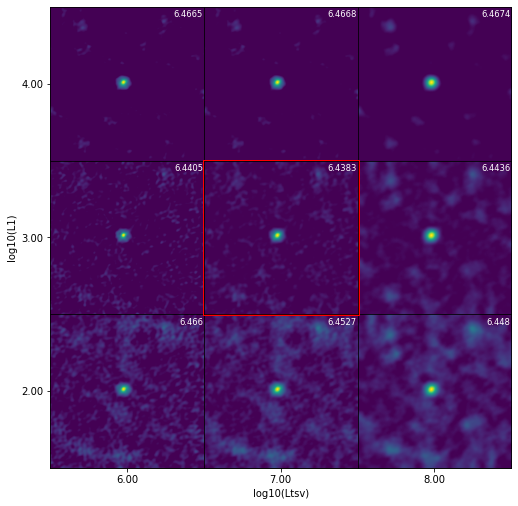

1min 46s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
%%timeit -n 1 -r 1
%%capture --no-display capture_cv

L1_list = [1e2, 1e3, 1e4]
Ltsv_list = [1e6, 1e7, 1e8]
num_fold = 4

cvname = 'twhya_b7cont.cv'
h.setSpParam(cvname=cvname, l1List=L1_list, ltsvList=Ltsv_list,
             maxiter=1000, numFold=num_fold, 
             optimizer='classical')
h.crossValidation(overwrite=True)

In [ ]:
print('# L1, ltsv, MSE ')
with open(cvname+'/'+cvname+'.cvresult.dat', "r") as f:
    next(f)
    for line in f:
        dat=line[:-1].split("\t")[0].split(',')
        print(f'{float(dat[0])},', f'{float(dat[1])},', f'{float(dat[2])}')

# L1, ltsv, MSE 
10000.0, 1000000.0, 6.466502268754963
1000.0, 1000000.0, 6.440546366116858
100.0, 1000000.0, 6.46603938767352
10000.0, 10000000.0, 6.46681137969432
1000.0, 10000000.0, 6.438348800601202
100.0, 10000000.0, 6.452674111599304
10000.0, 100000000.0, 6.467373060450672
1000.0, 100000000.0, 6.443646735056422
100.0, 100000000.0, 6.448037178434349


## Cross-Validation: Accelerating with Bayesian Optimization

The cross-validation method has an option to choose optimizer. Default optimizer is <code>'classical'</code> which evaluates each pair of <code>L1</code> and <code>Ltsv</code> in order to find the most reliable combination. In general, <code>'classical'</code> optimizer takes time because all combinations of given sets of <code>L1</code> and <code>Ltsv</code> must be evaluated. This makes practically difficult to search wide range of <code>L1</code> and <code>Ltsv</code>. To address this issue, we've introduced another optimizer, <code>'bayesian'</code>. The <code>'bayesian'</code> optimizer performs Bayesian optimization to reach the most reliable combination with less number of evaluation instead of evaluating individual hyperparameter pairs. Below is an example of obtaining the best result among 12&times;12 hyperparameters (144 pairs) with up to 15 evaluations, i.e. almost 1/10 of total number of combinations. You will see the same (or close) result to the one obtained by the <code>'classical'</code> optimizer. You can choose, or combine, these optimizers as needed to reach the best image. 
<br>
Here, the cross-validation images with the bayesian optimizer are shown, and the most reliable image is boxed in a red square. The most reliable image will be stored in "<code>cvbyname</code>.fits".
The files created here are placed under the directory "<code>cvbyname</code>".

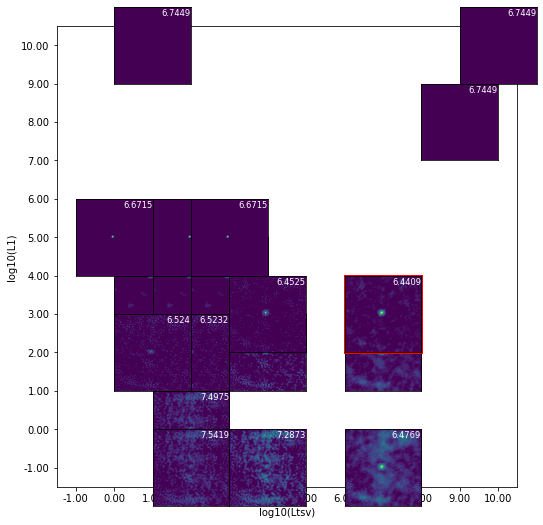

12min 55s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
%%timeit -n 1 -r 1
%%capture --no-display capture_cv

L1_list = [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
Ltsv_list =  [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
num_fold = 4

cvbyname = 'twhya_b7cont.cv_bay'
h.setSpParam(cvname=cvbyname, l1List=L1_list, ltsvList=Ltsv_list,
             maxiter=1000, numFold=num_fold,
             optimizer='bayesian', bayesopt_maxiter=15)
h.crossValidation(overwrite=True)

## Processing using a Parameter File

Imaging and cross-validation can be processed using parameters stored in a parameter file. 
For reading the parameter file, <code>loadParam</code> is used. 
And also, the used parameters can be stored by <code>saveParam</code> in a parameter file of <code>*.param</code>. 
(The parameters in cross-validations are automatically stored, such as "<code>cvname</code>.param".) 
You manually make the parameter file and can apply that for imaging and cross-validation as well. <br>

<br>
For example, you can perform imaging or cross-validation using the parameter file "test.param" as follows,
<pre style="width: 350px; margin: 10px; padding: solid 3px; background-color: #ffffe0;">
<code style="background-color: #ffffe0;">hh=runner.Session.loadParam('test.param')</code>
<code style="background-color: #ffffe0;">hh.run(overwrite=True)</code>
</pre>
or
<pre style="width: 350px; margin: 10px; padding: solid 3px; background-color: #ffffe0;">
<code style="background-color: #ffffe0;">hh=runner.Session.loadParam('test.param')</code>
<code style="background-color: #ffffe0;">hh.crossValidation(overwrite=True)</code>
</pre>

The sample of the parameter file for the classical cross-validation is as follows,
<pre style="width: 500px; margin: 10px; padding: solid 3px; background-color: #ffffe0;">
<code style="background-color: #ffffe0;">vis:            twhya_b7cont.smoothed.ms
field:          0
spw:            0
ch:             24~25
datacolumn:     data
imname:         twhya_b7cont.fits
imsize:         [256, 256]
cell:           ['0.08arcsec']
nchan:          1
start:          0
width:          2
cvname:         twhya_b7cont.cv
solver:         mfista_nufft
l1:             1000.0
ltsv:           10000000.0
maxiter:        1000
numFold:        4
imagePolicy:    full
l1List:         [100.0, 1000.0, 10000.0]
ltsvList:       [1000000.0, 10000000.0, 100000000.0]
optimizer:      classical
bayesopt_maxiter:       15</code>
</pre>

In [ ]:
#%%timeit -n 1 -r 1
#%%capture --no-display capture_cv
#hh=runner.Session.loadParam('twhya_b7cont.cv/twhya_b7cont.cv.param')
#hh.crossValidation(overwrite=True)

## Display Final Image

The created image is displayed here using the <code>matplotlib</code> modular. <br>
By default, if the final image with classical cross-validation exist, that is shown. Here, the area of 100&times;100 pixels around central region of the image is shown. 

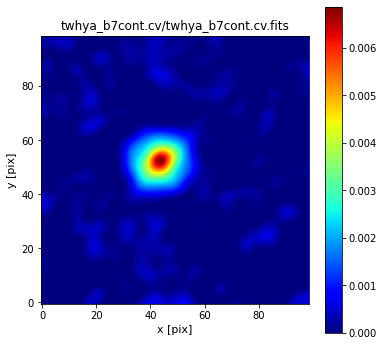

In [ ]:
from astropy.io import fits
from matplotlib import pyplot as plt

imname1 = dimname
imname2 = cvname+'/'+cvname+'.fits'
imname3 = cvbyname+'/'+cvbyname+'.fits'
imname = imname1
if os.path.isfile(imname2):
    imname = imname2
elif os.path.isfile(imname3):
    imname = imname3

pixs=256; imwd=100; exwd = (pixs-imwd) // 2
ff,aa=plt.subplots(1,1, figsize=(6,6))
im=aa.imshow(fits.getdata(imname)[0,0,exwd:((pixs-1)-exwd),exwd:((pixs-1)-exwd)], 
             origin='lower', cmap='jet')
#             vmin=0, vmax=0.010, origin='lower', cmap='jet')
cbar=plt.colorbar(im, ax=aa)
aa.set_title(imname)
aa.set_xlabel("x [pix]",size=11)
aa.set_ylabel("y [pix]",size=11)
plt.savefig(dimname.replace('fits','png'), bbox_inches="tight", pad_inches=0.05)
plt.show()